In [2]:
import geopandas as gpd
import pandas as pd
import pandas as pd
from shapely.geometry import Point
from shapely.ops import linemerge, Polygon
from shapely.wkt import loads
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

C:\Users\artir\Miniconda3\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.set_option('display.max_rows', None)

In [4]:
#only process new results from Pavimentados
df_old = pd.read_excel('', sheet_name = 'data_resulting' )
df_new = pd.read_excel('', sheet_name = 'data_resulting' )

In [5]:
print(df_old.shape[0])
print(df_new.shape[0])

1517
2353


In [9]:
defects_df = df_new[~df_new.apply(tuple, 1).isin(df_old.apply(tuple, 1))]

In [10]:
print(defects_df.shape[0])

836


In [13]:
#defects_df['Video Name'].value_counts()

In [14]:
defects_df.columns

Index(['Unnamed: 0', 'latitude', 'longitude', 'distances', 'ind', 'frame',
       'section', 'classes', 'ind2', 'scores', 'boxes', 'class_id', 'area',
       'center', 'height', 'width', 'total_area', 'perc_area',
       'fail_id_section', 'Video Name', 'fotograma', 'area_meters'],
      dtype='object')

In [15]:
# columns_to_extract = ['class_id', 'fail_id_section', 'start_latitude', 'start_longitude', 'distances', 'width', 'area',
#        'boxes', 'Video Name']

columns_to_extract = ['latitude', 'longitude', 'distances', 'ind', 'frame',
       'section', 'classes', 'ind2', 'scores', 'boxes', 'class_id', 'area',
       'center', 'height', 'width', 'total_area', 'perc_area',
       'fail_id_section', 'Video Name']

In [16]:
defects_df = defects_df[columns_to_extract]
defects_df.head()

,latitude,longitude,distances,ind,frame,section,classes,ind2,scores,boxes,class_id,area,center,height,width,total_area,perc_area,fail_id_section,Video Name
1489,5.819276,-57.052785,0.016472,30,40.0,0,Desenfoque Linea Blanca,30,0.746718,"[0.6428605318069458, 0.6380339860916138, 0.995...",Desenfoque Linea Blanca,506225.168254,"(2214.464807510376, 1235.5913400650024)",535.338974,945.616129,4110080,0.123167,0,Suriname\Results\GX011381 (2)
1490,5.819275,-57.052785,0.016472,32,49.0,0,Desenfoque Linea Blanca,33,0.790074,"[0.5988683104515076, 0.47626709938049316, 0.74...",Desenfoque Linea Blanca,144596.623182,"(1818.2841863632202, 905.6309223175049)",223.665161,646.487019,4110080,0.035181,1,Suriname\Results\GX011381 (2)
1491,5.819274,-57.052786,0.016472,35,57.0,0,Desenfoque Linea Blanca,36,0.713043,"[0.5906733274459839, 0.4366545081138611, 0.736...",Desenfoque Linea Blanca,148150.800797,"(1794.4756898880005, 851.4423561096191)",221.810961,667.914698,4110080,0.036046,1,Suriname\Results\GX011381 (2)
1492,5.817883,-57.053412,1.063324,41,92.0,2,Desenfoque Linea Blanca,42,0.903465,"[0.7138018608093262, 0.6676969528198242, 0.870...",Desenfoque Linea Blanca,206479.900059,"(2141.3703927993774, 1259.254093170166)",237.500181,869.388390,4110080,0.050237,4,Suriname\Results\GX011381 (2)
1493,5.816069,-57.054230,1.104771,45,112.0,4,Desenfoque Linea Blanca,46,0.704433,"[0.603104293346405, 0.4417392611503601, 0.7538...",Desenfoque Linea Blanca,137530.202188,"(1834.5605192184448, 840.1787185668945)",229.086609,600.341516,4110080,0.033462,7,Suriname\Results\GX011381 (2)


In [17]:
defects_df['boxes'] = defects_df['boxes'].apply(ast.literal_eval)

In [18]:
defects_df[['x_center', 'y_center', 'width_n', 'height_n']] = pd.DataFrame(defects_df['boxes'].to_list(), index=defects_df.index)

In [19]:
distance_to_road = 0.75
FOV_angle = 90 #linear

def estimate_defect_size(df):
    bbox_width = df['width'] #* 1920  # convert normalized values to pixels
    bbox_height = df['height'] #* 1080  # convert normalized values to pixels

    visible_road_length_meters = 2 * distance_to_road * math.tan(FOV_angle / 2) 

    # Calculate the scale factor (meters/pixel)
    width_scale_factor = 6.8 / 1920
    height_scale_factor = visible_road_length_meters/1080

    # Convert the width and height from pixels to meters
    defect_real_width = bbox_width * width_scale_factor
    defect_real_height = bbox_height * height_scale_factor  # Assuming the image height corresponds to the road width

    return pd.Series([defect_real_width, defect_real_height])

In [20]:
defects_df[['defect_real_width', 'defect_real_height']] = defects_df.apply(estimate_defect_size, axis=1)

In [21]:
defects_df['defect_area_m2'] = defects_df['defect_real_width'] * defects_df['defect_real_height']

In [23]:
defects_gdf = gpd.GeoDataFrame(defects_df, geometry = gpd.points_from_xy(defects_df.longitude, defects_df.latitude))

In [25]:
defects_gdf = defects_gdf.set_crs(crs=4326)

In [26]:
defects_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

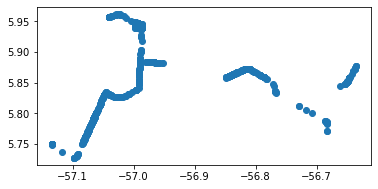

In [27]:
defects_gdf.plot()

In [28]:
defects_gdf.columns

Index(['latitude', 'longitude', 'distances', 'ind', 'frame', 'section',
       'classes', 'ind2', 'scores', 'boxes', 'class_id', 'area', 'center',
       'height', 'width', 'total_area', 'perc_area', 'fail_id_section',
       'Video Name', 'x_center', 'y_center', 'width_n', 'height_n',
       'defect_real_width', 'defect_real_height', 'defect_area_m2',
       'geometry'],
      dtype='object')

In [29]:
columns_to_extract2 = ['latitude', 'longitude', 'distances', 'ind', 'frame', 'section',
       'classes', 'ind2', 'scores', 'class_id', 'area', 'center',
       'height', 'width', 'total_area', 'perc_area', 'fail_id_section',
       'Video Name','defect_real_width', 'defect_real_height', 'defect_area_m2',
       'geometry']

In [30]:
defects_gdf = defects_gdf[columns_to_extract2]
defects_gdf.head()

,latitude,longitude,distances,ind,frame,section,classes,ind2,scores,class_id,...,height,width,total_area,perc_area,fail_id_section,Video Name,defect_real_width,defect_real_height,defect_area_m2,geometry
1489,5.819276,-57.052785,0.016472,30,40.0,0,Desenfoque Linea Blanca,30,0.746718,Desenfoque Linea Blanca,...,535.338974,945.616129,4110080,0.123167,0,Suriname\Results\GX011381 (2),3.349057,1.204346,4.033422,POINT (-57.05278 5.81928)
1490,5.819275,-57.052785,0.016472,32,49.0,0,Desenfoque Linea Blanca,33,0.790074,Desenfoque Linea Blanca,...,223.665161,646.487019,4110080,0.035181,1,Suriname\Results\GX011381 (2),2.289642,0.503177,1.152094,POINT (-57.05279 5.81928)
1491,5.819274,-57.052786,0.016472,35,57.0,0,Desenfoque Linea Blanca,36,0.713043,Desenfoque Linea Blanca,...,221.810961,667.914698,4110080,0.036046,1,Suriname\Results\GX011381 (2),2.365531,0.499005,1.180413,POINT (-57.05279 5.81927)
1492,5.817883,-57.053412,1.063324,41,92.0,2,Desenfoque Linea Blanca,42,0.903465,Desenfoque Linea Blanca,...,237.500181,869.388390,4110080,0.050237,4,Suriname\Results\GX011381 (2),3.079084,0.534301,1.645158,POINT (-57.05341 5.81788)
1493,5.816069,-57.054230,1.104771,45,112.0,4,Desenfoque Linea Blanca,46,0.704433,Desenfoque Linea Blanca,...,229.086609,600.341516,4110080,0.033462,7,Suriname\Results\GX011381 (2),2.126210,0.515373,1.095792,POINT (-57.05423 5.81607)


In [31]:
defects_gdf.to_file("")

C:\Users\artir\AppData\Local\Temp\ipykernel_12224\2853397450.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  defects_gdf.to_file("SectionID_SHP/Defects_NewProcessed/Pav_Failure_New.shp")
